# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal
import sys

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [6]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [7]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [8]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

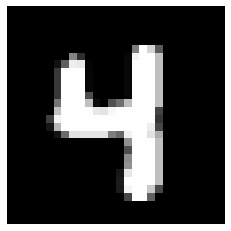

In [9]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [10]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [54]:


def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    for label in range(k):
        indices = (label == y)
        pi[label] = float(sum(indices)) / float(len(y))
        mu[label] = np.mean(x[indices],axis=0)
        sigma[label] = np.cov(x[indices], rowvar=False, bias=True)
    # Halt and return parameters
    return mu, sigma, pi

def regularize(sigma, c):
    """c: Constant to regularize the covariance matrices\n
    sigma: the covariance matrix"""   
    d = (sigma.shape)[1]  # number of features
     # Regularization ADD cI to sigma
    return sigma + c * (np.identity(d))
    

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

In [55]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)


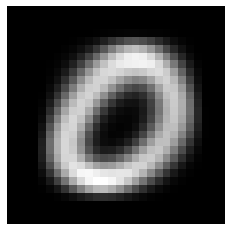

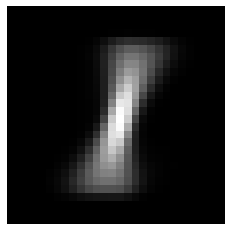

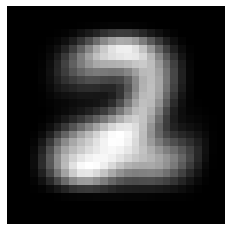

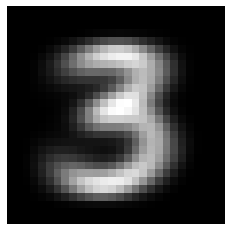

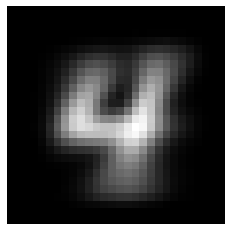

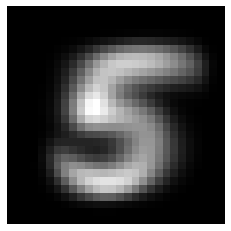

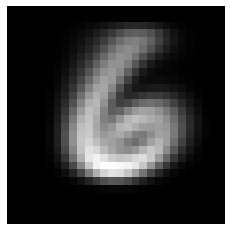

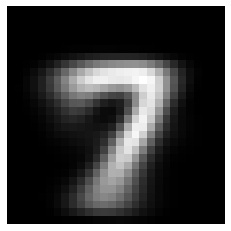

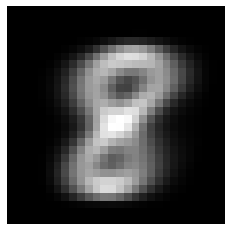

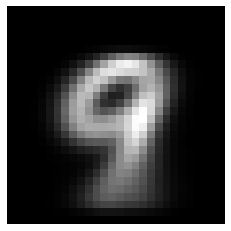

In [56]:
k = 10 # labels 0,1,...,k-1
for j in range(k):
    displaychar(mu[j])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [99]:
def compute_errors(c):
    # Compute log Pr(label|image) for each [test image,label] pair.
    score = np.zeros((len(test_labels),k))
    for label in range(0,k):
        rv = multivariate_normal(mean=mu[label], cov=regularize(sigma[label],c))
        for i in range(0,len(test_labels)):
           score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
    predictions = np.argmax(score, axis=1)
    # Finally, tally up score
    errors = np.sum(predictions != test_labels)
    print ("Your model makes " + str(errors) + " errors out of 10000")


In [65]:
compute_errors(1) #Compute errors using c = 1

Your model makes 1588 errors out of 10000


## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

##### The multivariate_normal function throws LinAlgError: singular matrix

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

In [66]:
compute_errors(1000000) #Compute errors using c = 1000000

Your model makes 3422 errors out of 10000


<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

In [87]:
FROM = -3
TO = 9

for c in np.logspace(FROM,TO,num=TO-FROM+1,base=10,dtype='float'):
    print("For c = " + str(c))
    compute_errors(c)
    print()

For c = 0.001
Your model makes 2468 errors out of 10000

For c = 0.01
Your model makes 2190 errors out of 10000

For c = 0.1
Your model makes 1891 errors out of 10000

For c = 1.0
Your model makes 1588 errors out of 10000

For c = 10.0
Your model makes 1226 errors out of 10000

For c = 100.0
Your model makes 805 errors out of 10000

For c = 1000.0
Your model makes 489 errors out of 10000

For c = 10000.0
Your model makes 508 errors out of 10000

For c = 100000.0
Your model makes 1443 errors out of 10000

For c = 1000000.0
Your model makes 3422 errors out of 10000

For c = 10000000.0
Your model makes 7929 errors out of 10000

For c = 100000000.0
Your model makes 8865 errors out of 10000

For c = 1000000000.0
Your model makes 8865 errors out of 10000



In [88]:
for c in range (100,1000,100):
    print("For c = " + str(c))
    compute_errors(c)
    print()
    
for c in range (1000,10000,1000):
    print("For c = " + str(c))
    compute_errors(c)
    print()

For c = 100
Your model makes 805 errors out of 10000

For c = 200
Your model makes 688 errors out of 10000

For c = 300
Your model makes 627 errors out of 10000

For c = 400
Your model makes 595 errors out of 10000

For c = 500
Your model makes 563 errors out of 10000

For c = 600
Your model makes 533 errors out of 10000

For c = 700
Your model makes 520 errors out of 10000

For c = 800
Your model makes 505 errors out of 10000

For c = 900
Your model makes 493 errors out of 10000

For c = 1000
Your model makes 489 errors out of 10000

For c = 2000
Your model makes 437 errors out of 10000

For c = 3000
Your model makes 435 errors out of 10000

For c = 4000
Your model makes 431 errors out of 10000

For c = 5000
Your model makes 438 errors out of 10000

For c = 6000
Your model makes 447 errors out of 10000

For c = 7000
Your model makes 472 errors out of 10000

For c = 8000
Your model makes 487 errors out of 10000

For c = 9000
Your model makes 500 errors out of 10000



<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

In [94]:
def compute_errors_ind(c):
    # Compute log Pr(label|image) for each [test image,label] pair.
    score = np.zeros((len(test_labels),k))
    for label in range(0,k):
        rv = multivariate_normal(mean=mu[label], cov=regularize(sigma[label],c[label]))
        for i in range(0,len(test_labels)):
           score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
    predictions = np.argmax(score, axis=1)
    # Finally, tally up score
    errors = np.sum(predictions != test_labels)
    print ("Your model makes " + str(errors) + " errors out of 10000")

FROM = -1
TO = 4    
for i in range(10):
    c = [10**FROM for x in range(10)]
    for c[i] in np.logspace(FROM,TO,num=TO-FROM+1,base=10,dtype='float'):
        print("For c = " + str(c))
        compute_errors_ind(c)
        print()


For c = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 1891 errors out of 10000

For c = [1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 2079 errors out of 10000

For c = [10.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 2501 errors out of 10000

For c = [100.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 2684 errors out of 10000

For c = [1000.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 2746 errors out of 10000

For c = [10000.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 2758 errors out of 10000

For c = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 1891 errors out of 10000

For c = [0.1, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 1924 errors out of 10000

For c = [0.1, 10.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model makes 2933 errors out of 10000

For c = [0.1, 100.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Your model

In [98]:
# From the c that gave the min error, variating one at the time:
for i in range(10):
    c = [4000 for x in range(10)]
    for c[i] in range(3900, 4100+1, 100):
        print("For c = " + str(c))
        compute_errors_ind(c)
        print()

For c = [3900, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 452 errors out of 10000

For c = [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 431 errors out of 10000

For c = [4100, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 424 errors out of 10000

For c = [4000, 3900, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 457 errors out of 10000

For c = [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 431 errors out of 10000

For c = [4000, 4100, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 408 errors out of 10000

For c = [4000, 4000, 3900, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 414 errors out of 10000

For c = [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 431 errors out of 10000

For c = [4000, 4000, 4100, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
Your model makes 464 errors out of 10000

F

In [101]:
c = [4100,4100,3900,4000,3900,3900,3900,3900,4000,4100]
compute_errors_ind(c)

Your model makes 437 errors out of 10000


#### Adjusting one parameter at a time does not improve significantly the performance.